In [15]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from fedot_ind.api.main import FedotIndustrial
from sklearn.model_selection import train_test_split
from fedot_ind.api.utils.checkers_collections import DataCheck

In [5]:
from typing import Optional

import numpy as np
from fedot.core.data.data import InputData
from fedot.core.operations.operation_parameters import OperationParameters
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from fedot_ind.core.models.base_extractor import BaseExtractor
from fedot_ind.core.repository.constanst_repository import KERNEL_BASELINE_FEATURE_GENERATORS
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels


class TabularExtractor(BaseExtractor):
    """Class responsible for quantile feature generator experiment.

    Attributes:
        window_size (int): size of window
        stride (int): stride for window
        var_threshold (float): threshold for variance

    Example:
        To use this class you need to import it and call needed methods::

            from fedot.core.pipelines.pipeline_builder import PipelineBuilder
            from examples.fedot.fedot_ex import init_input_data
            from fedot_ind.tools.loader import DataLoader
            from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels

            train_data, test_data = DataLoader(dataset_name='Ham').load_data()
            with IndustrialModels():
                pipeline = PipelineBuilder().add_node('quantile_extractor',
                                                       params={'window_size': 20, 'window_mode': True})
                                            .add_node('rf')
                                            .build()
                input_data = init_input_data(train_data[0], train_data[1])
                pipeline.fit(input_data)
                features = pipeline.predict(input_data)

    """

    def __init__(self, params: Optional[OperationParameters] = None):
        super().__init__(params)
        self.feature_domain = params.get('feature_domain', 'all')
        self.feature_params = params.get('feature_params', {})
        self.explained_dispersion = params.get('explained_dispersion', .975)
        self.reduce_dimension = params.get('reduce_dimension', True)

        self.repo = IndustrialModels().setup_repository()
        self.pca_is_fitted = False
        self.scaler = StandardScaler()
        self.pca = PCA(self.explained_dispersion)

    def _reduce_dim(self, features, target):
        if self.pca_is_fitted:
            return self.pca.transform(self.scaler.transform(features))
        else:
            self.pca_is_fitted = True
            return self.pca.fit_transform(self.scaler.fit_transform(features, target))

    def create_feature_matrix(self, feature_list: list):
        return np.concatenate([x.reshape(x.shape[0], x.shape[1] * x.shape[2])
                               for x in feature_list], axis=1).squeeze()

    def _transform(self, input_data: InputData) -> np.array:
        """
        Method for feature generation for all series
        """

        feature_list = self.generate_features_from_ts(input_data)
        self.predict = self.create_feature_matrix(feature_list)
        return self.predict if not self.reduce_dimension else self._reduce_dim(self.predict, input_data.target)

    def generate_features_from_ts(self,
                                  input_data: InputData,
                                  window_length: int = None) -> InputData:
        feature_domain_models = [model for model in KERNEL_BASELINE_FEATURE_GENERATORS]
        self.feature_list = []

        if not self.feature_domain.__contains__('all'):
            feature_domain_models = [model for model in feature_domain_models
                                     if model.__contains__(self.feature_domain)]

        for model_name in feature_domain_models:
            model = KERNEL_BASELINE_FEATURE_GENERATORS[model_name]
            model.heads[0].parameters['use_sliding_window'] = self.use_sliding_window
            model = model.build()
            self.feature_list.append(model.fit(input_data).predict)

        return self.feature_list

# Загрузка и разделение данных

In [5]:
sig_X = np.load('./sig_data.npy').swapaxes(1, 2)
sig_y = np.load('./sig_target.npy')
metric_names = ('f1', 'accuracy')
task_type = 'classification'
x_train, x_test, y_train, y_test = train_test_split(sig_X, sig_y, test_size=0.2, random_state=42)
train_data, test_data = (x_train, y_train), (x_test, y_test)

# Визуализация

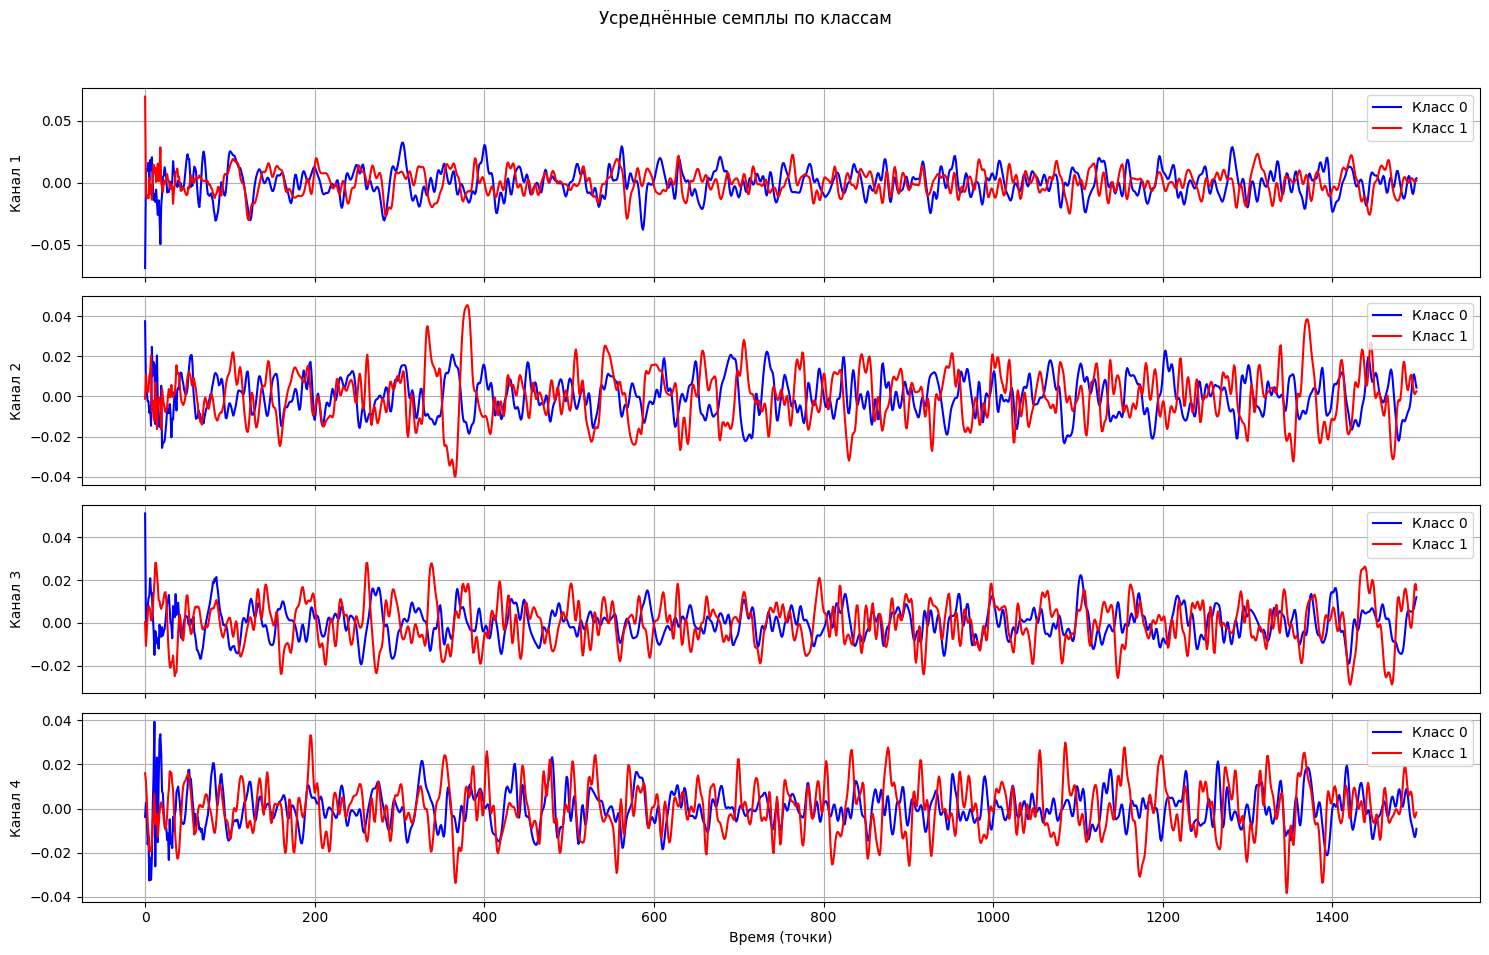

In [69]:
class_0_data = sig_X[sig_y == 0]  # Данные класса 0
class_1_data = sig_X[sig_y == 1]  # Данные класса 1

# Проверка, что оба класса имеют данные
if class_0_data.size == 0 or class_1_data.size == 0:
    raise ValueError("Один из классов не содержит данных.")

# Вычисление усреднённых семплов
average_class_0 = np.mean(class_0_data, axis=0)  # Размерность (4, 1500)
average_class_1 = np.mean(class_1_data, axis=0)  # Размерность (4, 1500)

# Визуализация усреднённых семплов
channels = ['Канал 1', 'Канал 2', 'Канал 3', 'Канал 4']
time = np.arange(1500)  # Предположим, что ось времени от 0 до 1499

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

for i in range(4):
    ax = axes[i]
    ax.plot(time, average_class_0[i], label='Класс 0', color='blue')
    ax.plot(time, average_class_1[i], label='Класс 1', color='red')
    ax.set_ylabel(channels[i])
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Время (точки)')
plt.suptitle('Усреднённые семплы по классам')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [113]:
fs = 250
nperseg = 64

In [107]:
n_channels = 4
angles = np.linspace(0, 2 * np.pi, n_channels, endpoint=False)
radius = 1  # Радиус окружности

# Создание словаря с позициями каналов и добавление небольших случайных смещений
ch_pos = {}
ch_names = ['Ch1', 'Ch2', 'Ch3', 'Ch4']
jitter_strength = 0.01  # Степень смещения

for i, name in enumerate(ch_names):
    x = radius * np.cos(angles[i]) + np.random.uniform(-jitter_strength, jitter_strength)
    y = radius * np.sin(angles[i]) + np.random.uniform(-jitter_strength, jitter_strength)
    z = 0  # Предполагаем, что все каналы находятся на одной плоскости
    ch_pos[name] = np.array([x, y, z])

# Создание объекта Montage
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')

# Создание объекта Info
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=['eeg'] * n_channels)
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Ch1, Ch2, Ch3, Ch4
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>

In [108]:
def plot_spectrogram(average_signal, title_prefix):
    channels = ['Канал 1', 'Канал 2', 'Канал 3', 'Канал 4']

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    for i in range(4):
        f, t, Sxx = signal.spectrogram(average_signal[i], fs=fs, nperseg=nperseg)
        ax = axes[i]
        im = ax.pcolormesh(t, f, Sxx, shading='gouraud')
        ax.set_ylabel('Частота [Гц]')
        ax.set_xlabel('Время [сек]')
        ax.set_title(f'{title_prefix} - {channels[i]}')
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

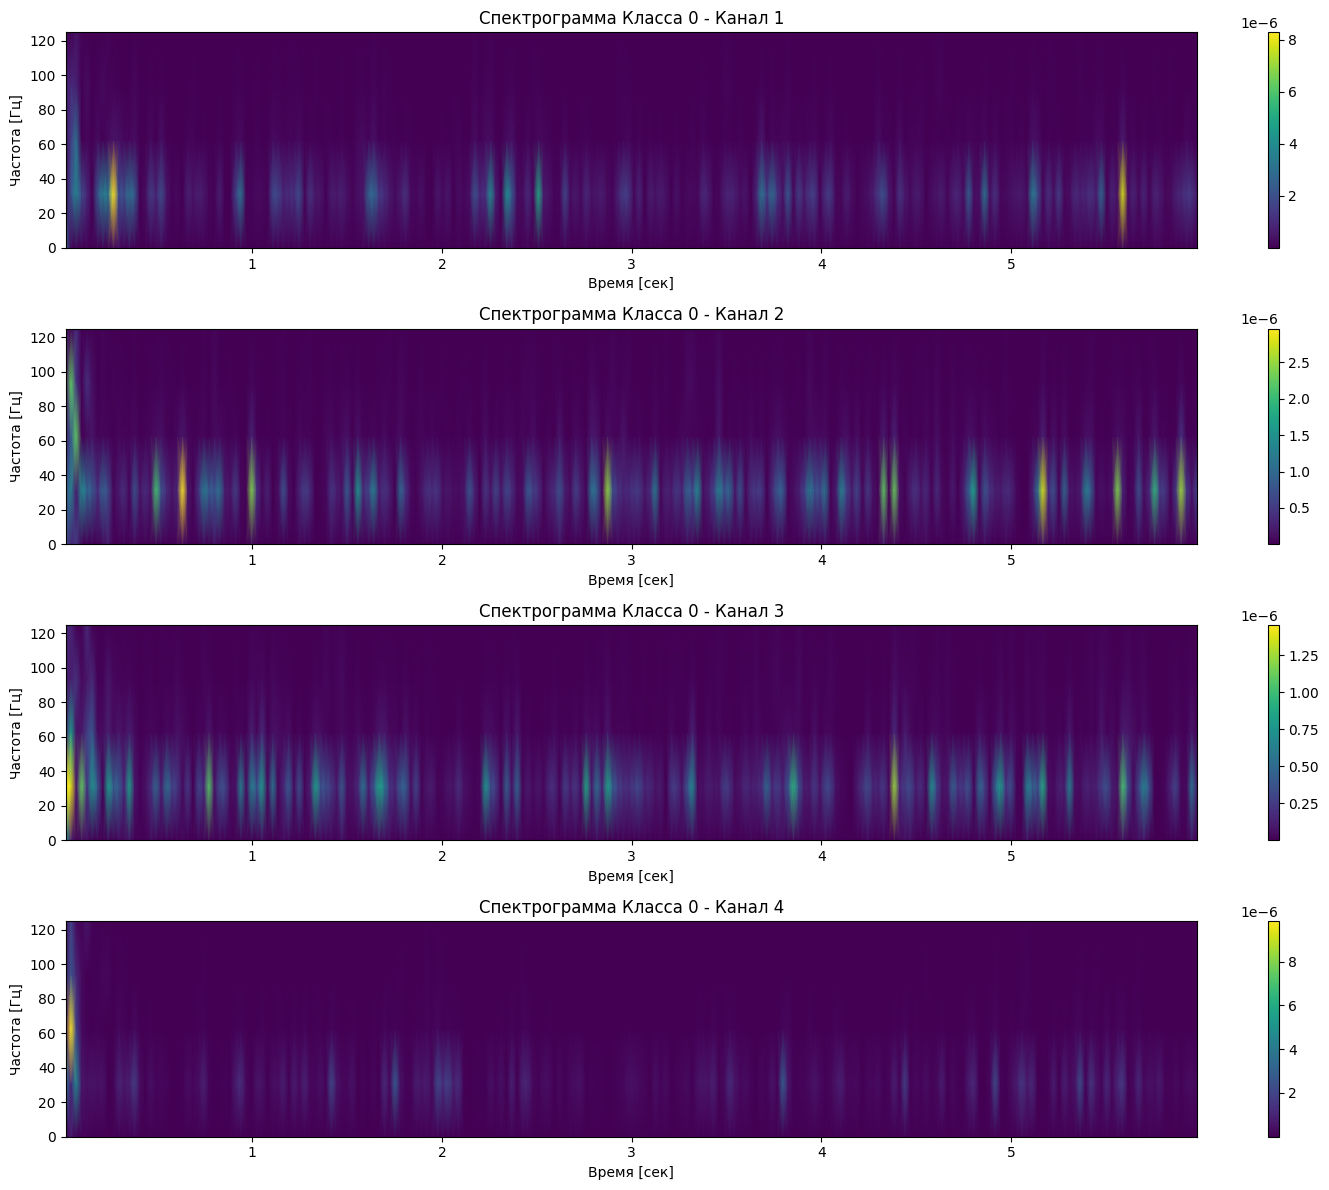

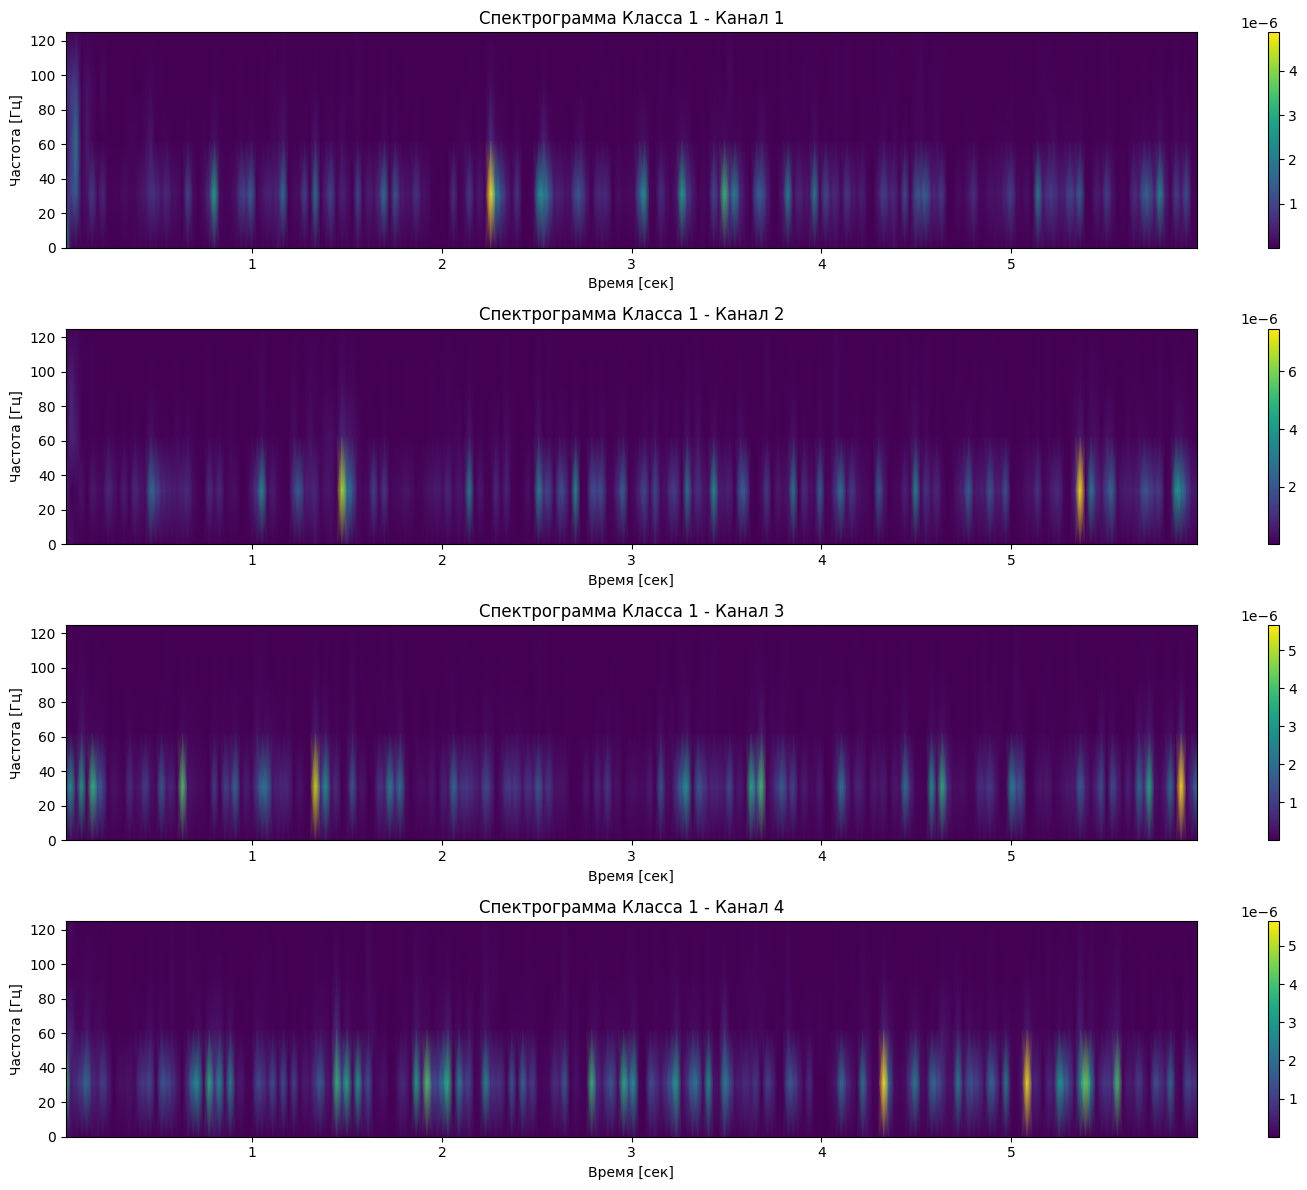

In [109]:
average_time_class_0 = np.mean(average_class_0, axis=1)
average_time_class_1 = np.mean(average_class_1, axis=1)

# Построение спектрограмм для каждого класса
plot_spectrogram(average_class_0, 'Спектрограмма Класса 0')
plot_spectrogram(average_class_1, 'Спектрограмма Класса 1')

Исходя из имеющихся спектрограмм можно сделать вывод о различиях, если обратить внимание на те, что отражают зависимость частоты от времени по 4 каналу - в случае с классом 1 (то есть в случае, если человек говорил правду) мозговая активность была выше для правого участка височной доли (T4).

In [114]:
def plot_power_spectrum(average_signal1, average_signal2, title_prefix):
    channels = ['Канал 1', 'Канал 2', 'Канал 3', 'Канал 4']

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    for i in range(4):
        f1, Pxx1 = signal.welch(average_signal1[i], fs=fs, nperseg=64)
        f2, Pxx2 = signal.welch(average_signal2[i], fs=fs, nperseg=64)
        ax = axes[i]
        ax.semilogy(f1, Pxx1)
        ax.semilogy(f2, Pxx2)
        ax.set_ylabel('Мощность [V**2/Гц]')
        ax.set_xlabel('Частота [Гц]')
        ax.set_title(f'Мощностный Спектр {title_prefix} - {channels[i]}')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

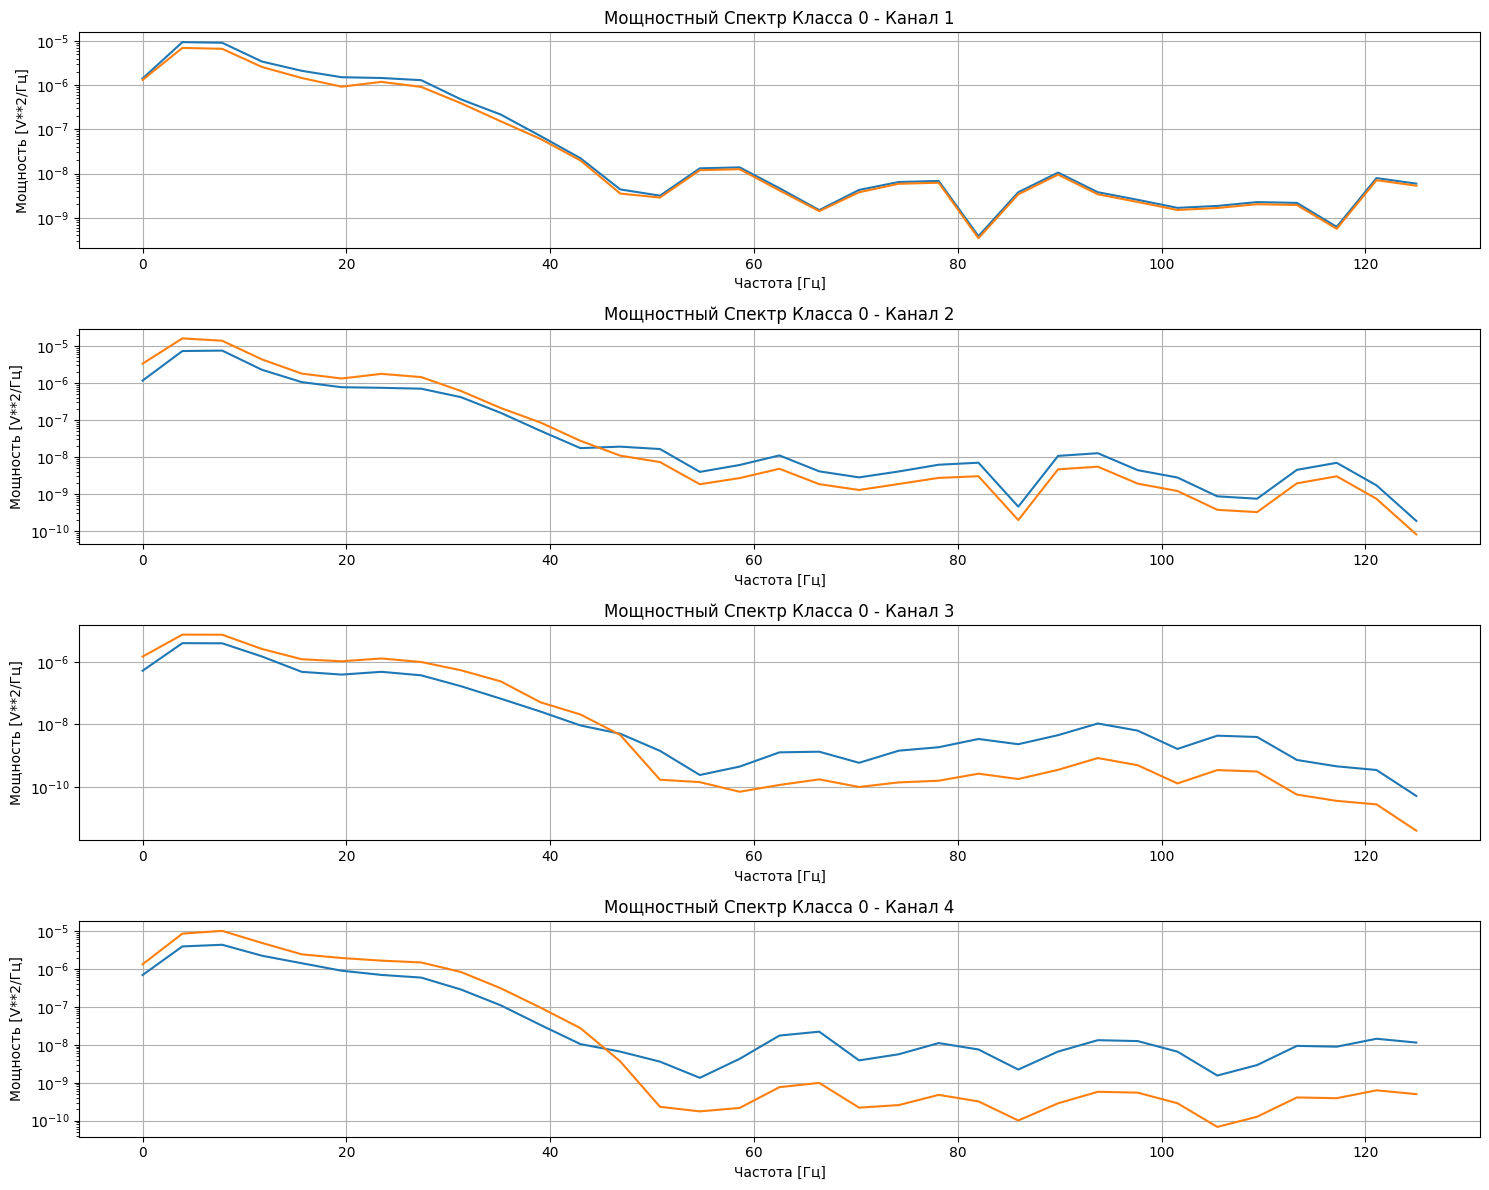

In [115]:
plot_power_spectrum(average_class_0, average_class_1, 'Класса 0')

In [50]:
def plot_topomap(average_signal, title_prefix, info):
    from mne.viz import plot_topomap

    # Усреднение по времени для топографической карты
    average_time = np.mean(average_signal, axis=1)  # Среднее по времени, размерность (4,)

    # Построение топографической карты
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    im, cm = plot_topomap(average_time, info, axes=ax, show=False, cmap='viridis')
    ax.set_title(f'{title_prefix} Топографическая Карта')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()

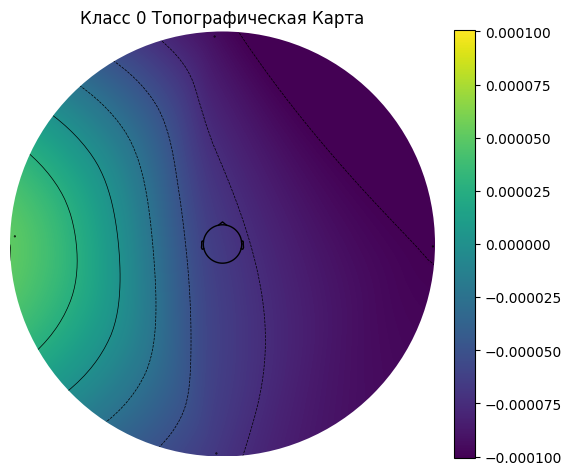

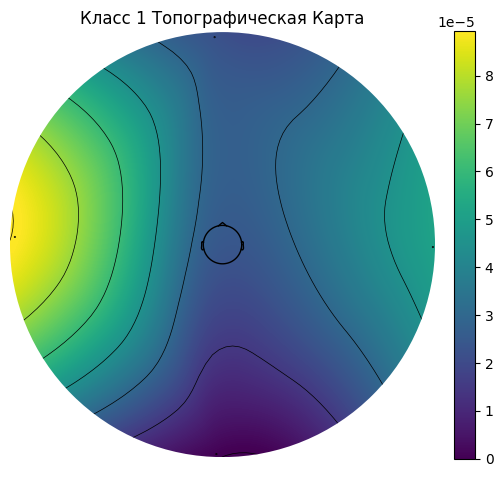

In [51]:
average_time_class_0 = np.mean(average_class_0, axis=1)
average_time_class_1 = np.mean(average_class_1, axis=1)

# Построение топографических карт для каждого класса
plot_topomap(average_class_0, 'Класс 0', info)
plot_topomap(average_class_1, 'Класс 1', info)

# Трансформация в тип данных совместимый с Индастриалом

In [ ]:
input_data_train = DataCheck(input_data=train_data, task=task_type, fit_stage=True).check_input_data()
input_data_test = DataCheck(input_data=test_data, task=task_type, fit_stage=True).check_input_data()

# Создание признакового представления из сырых данных ЭЭГ

In [ ]:
tabular_params = dict(feature_domain = 'all',
                      use_sliding_window = False)

In [ ]:
ts_to_tabular = TabularExtractor(tabular_params)

In [ ]:
feature_matrix_train = ts_to_tabular.transform(input_data_train)

In [ ]:
feature_train = ts_to_tabular.feature_list

In [ ]:
feature_matrix_test = ts_to_tabular.transform(input_data_test)

In [ ]:
feature_test = ts_to_tabular.feature_list

In [ ]:
train_data, test_data = (feature_matrix_train.predict, y_train), (feature_matrix_test.predict, y_test)

# Автоматическое создание модели классификации сигнала

In [ ]:
industrial = FedotIndustrial(problem='classification',
                             use_cache=False,
                             preset='classification_tabular',
                             timeout=15,
                             n_jobs=-1,
                             logging_level=20)

In [ ]:
industrial.fit(train_data)

Creating Dask Server
2024-09-30 15:08:08,406 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-30 15:08:08,411 - State start
2024-09-30 15:08:08,420 -   Scheduler at: inproc://10.64.4.172/14028/1
2024-09-30 15:08:08,421 -   dashboard at:  http://10.64.4.172:8787/status
2024-09-30 15:08:08,422 - Registering Worker plugin shuffle
2024-09-30 15:08:08,434 -       Start worker at: inproc://10.64.4.172/14028/4
2024-09-30 15:08:08,435 -          Listening to:          inproc10.64.4.172
2024-09-30 15:08:08,436 -           Worker name:                          0
2024-09-30 15:08:08,437 -          dashboard at:          10.64.4.172:65102
2024-09-30 15:08:08,438 - Waiting to connect to: inproc://10.64.4.172/14028/1
2024-09-30 15:08:08,438 - -------------------------------------------------
2024-09-30 15:08:08,439 -               Threads:                          8
2024-09-30 15:08:08,440 -                Memory:   

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
EvoGraphOptimizer - Generation num: 1 size: 1
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.731 node_number=0.100>']
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 20 individuals out of 21 in previous population were evaluated successfully.
EvoGraphOptimizer - Generation num: 2 size: 20
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.742 node_number=0.100>']
EvoGraphOptimizer - Next population size: 20; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 10 individuals out of 13 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 9 individuals out of 10 in previous population were evaluated succe

Generations:   0%|          | 1/10000 [00:19<54:36:34, 19.66s/gen]

EvoGraphOptimizer - Generation num: 3 size: 20
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.742 node_number=0.100>']
EvoGraphOptimizer - no improvements for 1 iterations
EvoGraphOptimizer - spent time: 0.3 min
EvoGraphOptimizer - Next mutation proba: 0.05; Next crossover proba: 0.95
EvoGraphOptimizer - Next population size: 34; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 12 individuals out of 14 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 13 individuals out of 15 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 31 using 3 attempt(s) with success rate 0.825
RandomAgent - len=32 nonzero=4 avg=-0

Generations:   0%|          | 2/10000 [00:36<50:17:13, 18.11s/gen]

EvoGraphOptimizer - Generation num: 4 size: 34
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.744 node_number=0.100>']
EvoGraphOptimizer - Next population size: 34; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 23 individuals out of 28 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 6 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 5 individuals out of 6 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 32 using 3 attempt(s) with success rate 0.755
RandomAgent - len=34 nonzero=4 avg=-0.537 std=0.465 min=-1.000 max=-0.021 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>

Generations:   0%|          | 3/10000 [00:50<44:22:09, 15.98s/gen]

EvoGraphOptimizer - Generation num: 5 size: 34
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - Next population size: 34; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 14 individuals out of 25 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 17 individuals out of 25 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 31 using 2 attempt(s) with success rate 0.657
RandomAgent - len=34 nonzero=5 avg=-0.619 std=0.468 min=-1.000 max=0.010 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_add: 'single_add'>, 0.0), (<MutationTypesEnum.single_drop: '

Generations:   0%|          | 4/10000 [01:05<43:55:03, 15.82s/gen]

EvoGraphOptimizer - Generation num: 6 size: 31
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 1 iterations
EvoGraphOptimizer - spent time: 1.1 min
EvoGraphOptimizer - Next mutation proba: 0.6202357138145096; Next crossover proba: 0.3797642861854904
EvoGraphOptimizer - Next population size: 55; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 14 individuals out of 21 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 10 individuals out of 16 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 16 individuals out of 20 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 7 individuals out of 12 in pr

Generations:   0%|          | 5/10000 [01:27<49:40:11, 17.89s/gen]

EvoGraphOptimizer - Generation num: 7 size: 55
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 2 iterations
EvoGraphOptimizer - spent time: 1.5 min
EvoGraphOptimizer - Next mutation proba: 0.2915524857640056; Next crossover proba: 0.7084475142359944
EvoGraphOptimizer - Next population size: 55; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 19 individuals out of 31 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 27 individuals out of 35 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 9 individuals out of 14 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 55 using 3 attempt(s) with success rate 0.432
RandomAg

Generations:   0%|          | 6/10000 [01:52<56:42:48, 20.43s/gen]

EvoGraphOptimizer - Generation num: 8 size: 55
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 3 iterations
EvoGraphOptimizer - spent time: 1.9 min
EvoGraphOptimizer - Next mutation proba: 0.5940944416766811; Next crossover proba: 0.40590555832331887
EvoGraphOptimizer - Next population size: 55; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 26 individuals out of 35 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 26 individuals out of 35 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 52 using 2 attempt(s) with success rate 0.425
RandomAgent - len=63 nonzero=40 avg=-0.327 std=0.424 min=-1.000 max=0.001 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), 

Generations:   0%|          | 7/10000 [02:11<55:32:07, 20.01s/gen]

EvoGraphOptimizer - Generation num: 9 size: 55
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 4 iterations
EvoGraphOptimizer - spent time: 2.2 min
EvoGraphOptimizer - Next mutation proba: 0.6190843869553077; Next crossover proba: 0.38091561304469235
EvoGraphOptimizer - Next population size: 55; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 27 individuals out of 39 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 27 individuals out of 34 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 54 using 2 attempt(s) with success rate 0.446
RandomAgent - len=61 nonzero=44 avg=-0.200 std=0.356 min=-1.000 max=0.005 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<

Generations:   0%|          | 8/10000 [02:38<61:43:38, 22.24s/gen]

EvoGraphOptimizer - Generation num: 10 size: 55
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 5 iterations
EvoGraphOptimizer - spent time: 2.6 min
EvoGraphOptimizer - Next mutation proba: 0.6402213036960854; Next crossover proba: 0.35977869630391457
EvoGraphOptimizer - Next population size: 55; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 30 individuals out of 43 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 31 individuals out of 42 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 61 using 2 attempt(s) with success rate 0.479
RandomAgent - len=62 nonzero=40 avg=-0.224 std=0.364 min=-1.000 max=0.003 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (

Generations:   0%|          | 9/10000 [02:56<57:41:45, 20.79s/gen]

EvoGraphOptimizer - Generation num: 11 size: 28
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 6 iterations
EvoGraphOptimizer - spent time: 2.9 min
EvoGraphOptimizer - Next mutation proba: 0.7261589737828731; Next crossover proba: 0.2738410262171269
EvoGraphOptimizer - Next population size: 28; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 20 individuals out of 24 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 9 individuals out of 10 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 29 using 2 attempt(s) with success rate 0.529
RandomAgent - len=35 nonzero=26 avg=-0.364 std=0.408 min=-1.000 max=0.003 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0), (

Generations:   0%|          | 10/10000 [03:10<51:35:33, 18.59s/gen]

EvoGraphOptimizer - Generation num: 12 size: 28
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 7 iterations
EvoGraphOptimizer - spent time: 3.2 min
EvoGraphOptimizer - Next mutation proba: 0.7568230268820664; Next crossover proba: 0.24317697311793363
EvoGraphOptimizer - Next population size: 28; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 17 individuals out of 20 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 11 individuals out of 15 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 28 using 2 attempt(s) with success rate 0.551
RandomAgent - len=34 nonzero=25 avg=-0.284 std=0.413 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0),

Generations:   0%|          | 11/10000 [03:19<44:10:35, 15.92s/gen]

EvoGraphOptimizer - Generation num: 13 size: 28
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 8 iterations
EvoGraphOptimizer - spent time: 3.3 min
EvoGraphOptimizer - Next mutation proba: 0.8449845083839029; Next crossover proba: 0.15501549161609707
EvoGraphOptimizer - Next population size: 28; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 20 individuals out of 23 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 7 individuals out of 9 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 27 using 2 attempt(s) with success rate 0.582
RandomAgent - len=31 nonzero=25 avg=-0.228 std=0.351 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0), (

Generations:   0%|          | 12/10000 [03:33<41:49:18, 15.07s/gen]

EvoGraphOptimizer - Generation num: 14 size: 28
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 9 iterations
EvoGraphOptimizer - spent time: 3.6 min
EvoGraphOptimizer - Next mutation proba: 0.8614677552414379; Next crossover proba: 0.13853224475856207
EvoGraphOptimizer - Next population size: 28; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 16 individuals out of 20 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 12 individuals out of 16 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 28 using 2 attempt(s) with success rate 0.600
RandomAgent - len=35 nonzero=27 avg=-0.300 std=0.421 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0),

Generations:   0%|          | 13/10000 [03:47<41:12:48, 14.86s/gen]

EvoGraphOptimizer - Generation num: 15 size: 28
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 10 iterations
EvoGraphOptimizer - spent time: 3.8 min
EvoGraphOptimizer - Next mutation proba: 0.8912044020970271; Next crossover proba: 0.10879559790297288
EvoGraphOptimizer - Next population size: 28; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 15 individuals out of 20 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 12 individuals out of 13 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 27 using 2 attempt(s) with success rate 0.600
RandomAgent - len=32 nonzero=30 avg=-0.202 std=0.362 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), 

Generations:   0%|          | 14/10000 [03:56<36:42:29, 13.23s/gen]

EvoGraphOptimizer - Generation num: 16 size: 10
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 11 iterations
EvoGraphOptimizer - spent time: 3.9 min
EvoGraphOptimizer - Next mutation proba: 0.8707341603757669; Next crossover proba: 0.1292658396242331
EvoGraphOptimizer - Next population size: 10; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 6 individuals out of 8 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 9 using 2 attempt(s) with success rate 0.589
RandomAgent - len=13 nonzero=12 avg=-0.364 std=0.453 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<Muta

Generations:   0%|          | 15/10000 [03:59<27:34:12,  9.94s/gen]

EvoGraphOptimizer - Generation num: 17 size: 10
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 12 iterations
EvoGraphOptimizer - spent time: 4.0 min
EvoGraphOptimizer - Next mutation proba: 0.05; Next crossover proba: 0.95
EvoGraphOptimizer - Next population size: 10; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 6 individuals out of 9 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 11 using 2 attempt(s) with success rate 0.611
RandomAgent - len=12 nonzero=3 avg=-0.682 std=0.449 min=-1.000 max=-0.048 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<MutationTypesEnum.single_drop: 

Generations:   0%|          | 16/10000 [04:02<21:40:40,  7.82s/gen]

EvoGraphOptimizer - Generation num: 18 size: 10
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 13 iterations
EvoGraphOptimizer - spent time: 4.0 min
EvoGraphOptimizer - Next mutation proba: 0.9676428370235942; Next crossover proba: 0.032357162976405784
EvoGraphOptimizer - Next population size: 10; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 5 individuals out of 8 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 7 in previous population were evaluated successfully. 0.42857142857142855% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproducti

Generations:   0%|          | 17/10000 [04:06<19:08:20,  6.90s/gen]

EvoGraphOptimizer - Generation num: 19 size: 10
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 14 iterations
EvoGraphOptimizer - spent time: 4.1 min
EvoGraphOptimizer - Next mutation proba: 0.15372160918491506; Next crossover proba: 0.8462783908150849
EvoGraphOptimizer - Next population size: 10; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 5 individuals out of 6 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 7 in previous population were evaluated successfully. 0.42857142857142855% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 0 individuals out of 3 in previous population were evaluated successfully. 0.0% is a fairly small percentage of

Generations:   0%|          | 18/10000 [04:20<24:30:42,  8.84s/gen]

EvoGraphOptimizer - Generation num: 20 size: 10
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 15 iterations
EvoGraphOptimizer - spent time: 4.3 min
EvoGraphOptimizer - Next mutation proba: 0.11993157685492073; Next crossover proba: 0.8800684231450793
EvoGraphOptimizer - Next population size: 10; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 7 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 6 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 2 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
ReproductionController - Reproduction achieved pop s

Generations:   0%|          | 19/10000 [04:41<35:03:15, 12.64s/gen]

EvoGraphOptimizer - Generation num: 21 size: 6
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 16 iterations
EvoGraphOptimizer - spent time: 4.7 min
EvoGraphOptimizer - Next mutation proba: 0.5963436574384386; Next crossover proba: 0.40365634256156135
EvoGraphOptimizer - Next population size: 6; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 3 in previous population were evaluated successfully. 0.3333333333333333% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction a

Generations:   0%|          | 20/10000 [04:51<32:44:43, 11.81s/gen]

EvoGraphOptimizer - Generation num: 22 size: 6
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 17 iterations
EvoGraphOptimizer - spent time: 4.9 min
EvoGraphOptimizer - Next mutation proba: 0.05; Next crossover proba: 0.95
EvoGraphOptimizer - Next population size: 6; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 6 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 2 attempt(s) with success rate 0.585
RandomAgent - len=9 nonzero=4 avg=-0.750 std=0.434 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_drop: 'single_drop'>, -1.0), (<MutationTypesEnum.single_edge: 'si

Generations:   0%|          | 21/10000 [05:00<30:19:32, 10.94s/gen]

EvoGraphOptimizer - Generation num: 23 size: 6
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 18 iterations
EvoGraphOptimizer - spent time: 5.0 min
EvoGraphOptimizer - Next mutation proba: 0.4791811497778823; Next crossover proba: 0.5208188502221177
EvoGraphOptimizer - Next population size: 6; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 6 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size

Generations:   0%|          | 22/10000 [05:07<26:42:26,  9.64s/gen]

EvoGraphOptimizer - Generation num: 24 size: 6
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 19 iterations
EvoGraphOptimizer - spent time: 5.1 min
EvoGraphOptimizer - Next mutation proba: 0.8086057647748344; Next crossover proba: 0.19139423522516563
EvoGraphOptimizer - Next population size: 6; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 5 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 2 attempt(s) with success rate 0.585
RandomAgent - len=9 nonzero=9 avg=-0.357 std=0.457 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_change: 'single_change'>, -1.0), (<M

Generations:   0%|          | 23/10000 [05:09<20:20:02,  7.34s/gen]

EvoGraphOptimizer - Generation num: 25 size: 6
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 20 iterations
EvoGraphOptimizer - spent time: 5.2 min
EvoGraphOptimizer - Next mutation proba: 0.8086057647748344; Next crossover proba: 0.19139423522516563
EvoGraphOptimizer - Next population size: 6; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 7 using 3 attempt(s) with success rate 0.585
RandomAgent -

Generations:   0%|          | 24/10000 [05:13<17:47:10,  6.42s/gen]

EvoGraphOptimizer - Generation num: 26 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 21 iterations
EvoGraphOptimizer - spent time: 5.2 min
EvoGraphOptimizer - Next mutation proba: 0.7983543556311041; Next crossover proba: 0.20164564436889587
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 3 in previous population were evaluated successfully. 0.3333333333333333% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction a

Generations:   0%|          | 25/10000 [05:33<29:01:19, 10.47s/gen]

EvoGraphOptimizer - Generation num: 27 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 22 iterations
EvoGraphOptimizer - spent time: 5.6 min
EvoGraphOptimizer - Next mutation proba: 0.8081141600357604; Next crossover proba: 0.19188583996423958
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 2 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 4 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evalua

Generations:   0%|          | 26/10000 [05:36<23:18:33,  8.41s/gen]

EvoGraphOptimizer - Generation num: 28 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 23 iterations
EvoGraphOptimizer - spent time: 5.6 min
EvoGraphOptimizer - Next mutation proba: 0.9617745132911353; Next crossover proba: 0.03822548670886472
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 2 attempt(s) with success rate 0.585
RandomAgent - len=7 nonzero=7 avg=-0.332 std=0.430 min=-1.000 max=0.001 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0), (<Mutat

Generations:   0%|          | 27/10000 [05:40<19:38:47,  7.09s/gen]

EvoGraphOptimizer - Generation num: 29 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 24 iterations
EvoGraphOptimizer - spent time: 5.7 min
EvoGraphOptimizer - Next mutation proba: 0.9571531636950594; Next crossover proba: 0.04284683630494057
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 5 using 2 attempt(s) with success rate 0.585
RandomAgent - len=5 nonzero=5 avg=-0.061 std=0.052 min=-0.147 max=-0.003 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -0.0259), (<M

Generations:   0%|          | 28/10000 [05:45<17:26:03,  6.29s/gen]

EvoGraphOptimizer - Generation num: 30 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 25 iterations
EvoGraphOptimizer - spent time: 5.8 min
EvoGraphOptimizer - Next mutation proba: 0.9571531636950594; Next crossover proba: 0.04284683630494057
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 2 attempt(s) with success rate 0.585
RandomAgent - len=6 nonzero=6 avg=-0.226 std=0.352 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0), (<Mutat

Generations:   0%|          | 29/10000 [05:51<17:44:15,  6.40s/gen]

EvoGraphOptimizer - Generation num: 31 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 26 iterations
EvoGraphOptimizer - spent time: 5.9 min
EvoGraphOptimizer - Next mutation proba: 0.7682504773624003; Next crossover proba: 0.23174952263759974
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 2 attempt(s) with success rate 0.585
RandomAgent - len=7 nonzero=5 avg=-0.473 std=0.446 min=-1.000 max=-0.003 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0), (<Muta

Generations:   0%|          | 30/10000 [05:56<15:55:06,  5.75s/gen]

EvoGraphOptimizer - Generation num: 32 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 27 iterations
EvoGraphOptimizer - spent time: 5.9 min
EvoGraphOptimizer - Next mutation proba: 0.8267780352456171; Next crossover proba: 0.1732219647543829
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 0 individuals out of 3 in previous population were evaluated successfully. 0.0% is a fairly small percentage of successful evaluation.
PipelineObjectiveEvaluate - Unsuccessful pipeline fit during fitness evaluation. Skipping the pipeline. Exception <Found array with dim 4. MinMaxScaler expected <= 2.> on ((((/n_resample_{'balance': 'expand_minority', 'replace': False, 'balance_ratio': 1};)/n_normalization;)/n_normalization;)/n_scaling;)/n_rf_{'n_jobs': 1, 'criterion': 'gini', 'max_features': 0.1

Generations:   0%|          | 31/10000 [06:00<14:27:38,  5.22s/gen]

EvoGraphOptimizer - Generation num: 33 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 28 iterations
EvoGraphOptimizer - spent time: 6.0 min
EvoGraphOptimizer - Next mutation proba: 0.766046845189612; Next crossover proba: 0.23395315481038803
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 3 attempt(s) with success rate 0.585
RandomAgent - 

Generations:   0%|          | 32/10000 [06:03<13:05:28,  4.73s/gen]

EvoGraphOptimizer - Generation num: 34 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 29 iterations
EvoGraphOptimizer - spent time: 6.1 min
EvoGraphOptimizer - Next mutation proba: 0.05; Next crossover proba: 0.95
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 5 using 3 attempt(s) with success rate 0.585
RandomAgent - len=6 nonzero=1 avg=-1.000 s

Generations:   0%|          | 33/10000 [06:06<11:42:30,  4.23s/gen]

EvoGraphOptimizer - Generation num: 35 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 30 iterations
EvoGraphOptimizer - spent time: 6.1 min
EvoGraphOptimizer - Next mutation proba: 0.8448402354169886; Next crossover proba: 0.1551597645830114
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 4 in previous population were evaluated successfully. 0.25% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop siz

Generations:   0%|          | 34/10000 [06:13<14:04:32,  5.08s/gen]

EvoGraphOptimizer - Generation num: 36 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 31 iterations
EvoGraphOptimizer - spent time: 6.2 min
EvoGraphOptimizer - Next mutation proba: 0.8030587152494763; Next crossover proba: 0.19694128475052375
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 7 using 2 attempt(s) with success rate 0.585
RandomAgent - len=8 nonzero=4 avg=-0.746 std=0.440 min=-1.000 max=0.016 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0), (<Mutat

Generations:   0%|          | 35/10000 [06:16<12:22:50,  4.47s/gen]

EvoGraphOptimizer - Generation num: 37 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 32 iterations
EvoGraphOptimizer - spent time: 6.3 min
EvoGraphOptimizer - Next mutation proba: 0.9625834985431662; Next crossover proba: 0.03741650145683384
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 3 attempt(s) with success rate 0.585
RandomAgent -

Generations:   0%|          | 36/10000 [06:21<12:31:26,  4.52s/gen]

EvoGraphOptimizer - Generation num: 38 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 33 iterations
EvoGraphOptimizer - spent time: 6.4 min
EvoGraphOptimizer - Next mutation proba: 0.9625834985431662; Next crossover proba: 0.03741650145683384
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 3 in previous population were evaluated successfully. 0.3333333333333333% is a fairly small percentage of successful evaluation.
ReproductionController - Reproduction a

Generations:   0%|          | 37/10000 [06:26<13:06:29,  4.74s/gen]

EvoGraphOptimizer - Generation num: 39 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 34 iterations
EvoGraphOptimizer - spent time: 6.4 min
EvoGraphOptimizer - Next mutation proba: 0.9625834985431662; Next crossover proba: 0.03741650145683384
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 8 using 2 attempt(s) with success rate 0.585
RandomAgent - len=6 nonzero=5 avg=-0.248 std=0.379 min=-1.000 max=-0.003 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<Mutati

Generations:   0%|          | 38/10000 [06:32<13:37:03,  4.92s/gen]

EvoGraphOptimizer - Generation num: 40 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 35 iterations
EvoGraphOptimizer - spent time: 6.5 min
EvoGraphOptimizer - Next mutation proba: 0.8253586596141566; Next crossover proba: 0.17464134038584345
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 2 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop siz

Generations:   0%|          | 39/10000 [06:38<15:08:58,  5.48s/gen]

EvoGraphOptimizer - Generation num: 41 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 36 iterations
EvoGraphOptimizer - spent time: 6.7 min
EvoGraphOptimizer - Next mutation proba: 0.9655478313077709; Next crossover proba: 0.03445216869222911
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 4 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
ReproductionController - Reproduction achieved pop size 5 using 2 attempt(s) with success rate 0.585
RandomAgent - len=6 nonzero=5 avg=-0.315 std=0.371 min=-1.000 max=0.003 
RandomAgent - actions/rewards: [(<M

Generations:   0%|          | 40/10000 [06:41<12:49:38,  4.64s/gen]

EvoGraphOptimizer - Generation num: 42 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 37 iterations
EvoGraphOptimizer - spent time: 6.7 min
EvoGraphOptimizer - Next mutation proba: 0.8016176549701584; Next crossover proba: 0.19838234502984164
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 7 using 3 attempt(s) with success rate 0.585
RandomAgent -

Generations:   0%|          | 41/10000 [06:45<11:59:29,  4.33s/gen]

EvoGraphOptimizer - Generation num: 43 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 38 iterations
EvoGraphOptimizer - spent time: 6.8 min
EvoGraphOptimizer - Next mutation proba: 0.9768120919806564; Next crossover proba: 0.02318790801934356
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 3 in previous population were evaluated successfully. 0.3333333333333333% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 2 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were eva

Generations:   0%|          | 42/10000 [06:48<11:17:59,  4.09s/gen]

EvoGraphOptimizer - Generation num: 44 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 39 iterations
EvoGraphOptimizer - spent time: 6.8 min
EvoGraphOptimizer - Next mutation proba: 0.9819823302105367; Next crossover proba: 0.018017669789463286
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 5 using 2 attempt(s) with success rate 0.585
RandomAgent - len=8 nonzero=7 avg=-0.460 std=0.470 min=-1.000 max=0.002 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_edge: 'single_edge'>, -1.0), (<Muta

Generations:   0%|          | 43/10000 [06:53<11:31:44,  4.17s/gen]

EvoGraphOptimizer - Generation num: 45 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 40 iterations
EvoGraphOptimizer - spent time: 6.9 min
EvoGraphOptimizer - Next mutation proba: 0.9819823302105367; Next crossover proba: 0.018017669789463286
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 0 individuals out of 1 in previous population were evaluated successfully. 0.0% is a fairly small percentage of successful evaluation.
PipelineObjectiveEvaluate - Unsuccessful pipeline fit during fitness evaluation. Skipping the pipeline. Exception <Found array with dim 4. StandardScaler expected <= 2.> on ((/n_resample_{'balance': 'expand_m

Generations:   0%|          | 44/10000 [07:01<14:50:31,  5.37s/gen]

EvoGraphOptimizer - Generation num: 46 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 41 iterations
EvoGraphOptimizer - spent time: 7.0 min
EvoGraphOptimizer - Next mutation proba: 0.7625783534274; Next crossover proba: 0.2374216465726
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 7 using 3 attempt(s) with success rate 0.585
RandomAgent - len=6 

Generations:   0%|          | 45/10000 [07:06<14:23:07,  5.20s/gen]

EvoGraphOptimizer - Generation num: 47 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 42 iterations
EvoGraphOptimizer - spent time: 7.1 min
EvoGraphOptimizer - Next mutation proba: 0.9646754864546135; Next crossover proba: 0.03532451354538646
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 2 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
Mu

Generations:   0%|          | 46/10000 [07:12<15:39:12,  5.66s/gen]

EvoGraphOptimizer - Generation num: 48 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 43 iterations
EvoGraphOptimizer - spent time: 7.2 min
EvoGraphOptimizer - Next mutation proba: 0.9768120919806564; Next crossover proba: 0.02318790801934356
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 5 using 2 attempt(s) with success rate 0.585
RandomAgent - len=5 nonzero=5 avg=-0.096 std=0.079 min=-0.188 max=-0.003 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -0.0027), (<Mut

Generations:   0%|          | 47/10000 [07:14<12:26:39,  4.50s/gen]

EvoGraphOptimizer - Generation num: 49 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 44 iterations
EvoGraphOptimizer - spent time: 7.2 min
EvoGraphOptimizer - Next mutation proba: 0.158304993401146; Next crossover proba: 0.841695006598854
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 3 in previous population were evaluated successfully. 0.3333333333333333% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
ReproductionController - Reproduction achi

Generations:   0%|          | 48/10000 [07:19<12:36:16,  4.56s/gen]

EvoGraphOptimizer - Generation num: 50 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 45 iterations
EvoGraphOptimizer - spent time: 7.3 min
EvoGraphOptimizer - Next mutation proba: 0.6650632398189014; Next crossover proba: 0.33493676018109864
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 6 using 2 attempt(s) with success rate 0.585
RandomAgent - len=6 nonzero=3 avg=-0.426 std=0.414 min=-1.000 max=-0.037 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<Mutati

Generations:   0%|          | 49/10000 [07:22<11:10:17,  4.04s/gen]

EvoGraphOptimizer - Generation num: 51 size: 4
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 46 iterations
EvoGraphOptimizer - spent time: 7.4 min
EvoGraphOptimizer - Next mutation proba: 0.48126568206241604; Next crossover proba: 0.518734317937584
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 5 using 2 attempt(s) with success rate 0.585
RandomAgent - len=5 nonzero=2 avg=0.011 std=0.012 min=-0.001 max=0.022 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_change: 'single_change'>, 0.0), (<Muta

Generations:   0%|          | 50/10000 [07:24<9:57:42,  3.60s/gen] 

EvoGraphOptimizer - Generation num: 52 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 47 iterations
EvoGraphOptimizer - spent time: 7.4 min
EvoGraphOptimizer - Next mutation proba: 0.4525337322506391; Next crossover proba: 0.5474662677493609
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 2 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size

Generations:   1%|          | 51/10000 [07:31<12:35:42,  4.56s/gen]

EvoGraphOptimizer - Generation num: 53 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 48 iterations
EvoGraphOptimizer - spent time: 7.5 min
EvoGraphOptimizer - Next mutation proba: 0.6643260826213313; Next crossover proba: 0.3356739173786687
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 2 individuals out of 3 in previous population were evaluated successfully.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 4 in previous population were evaluated successfully.
ReproductionController - Reproduction achieved pop size 5 using 2 attempt(s) with success rate 0.585
RandomAgent - len=6 nonzero=5 avg=-0.250 std=0.381 min=-1.000 max=-0.003 
RandomAgent - actions/rewards: [(<MutationTypesEnum.single_add: 'single_add'>, -1.0), (<Mutatio

Generations:   1%|          | 52/10000 [07:34<11:00:27,  3.98s/gen]

EvoGraphOptimizer - Generation num: 54 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 49 iterations
EvoGraphOptimizer - spent time: 7.6 min
EvoGraphOptimizer - Next mutation proba: 0.5287950334943368; Next crossover proba: 0.47120496650566324
EvoGraphOptimizer - Next population size: 5; max graph depth: 6
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 4 in previous population were evaluated successfully. 0.25% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 1 individuals out of 2 in previous population were evaluated successfully. 0.5% is a fairly small percentage of successful evaluation.
MultiprocessingDispatcher - Number of used CPU's: 8
MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated success

Generations:   1%|          | 53/10000 [07:36<10:01:02,  3.63s/gen]

EvoGraphOptimizer - Generation num: 55 size: 5
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 50 iterations
EvoGraphOptimizer - spent time: 7.6 min
GroupedCondition - Optimisation finished: Early stopping iterations criteria was satisfied


Generations:   1%|          | 53/10000 [07:36<23:49:26,  8.62s/gen]

OptimisationTimer - Composition time: 7.617 min
EvoGraphOptimizer - Generation num: 56 size: 1
EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<roc_auc_pen=-0.753 node_number=0.100>']
EvoGraphOptimizer - no improvements for 51 iterations
EvoGraphOptimizer - spent time: 7.6 min
GPComposer - GP composition finished
DataSourceSplitter - K-folds cross validation is applied.
ApiComposer - Hyperparameters tuning started with 7 min. timeout
SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 1, 'criterion': 'gini', 'max_features': 0.1060482801672528, 'min_samples_split': 4, 'min_samples_leaf': 15, 'bootstrap': False} 
Initial metric: [0.753]
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]2024-09-30 15:15:48,872 - build_posterior_wrapper took 0.005005 seconds
2024-09-30 15:15:48,872 - TPE using 0 trials
  0%|          | 1/100000 [00:00<?, ?trial/s, best loss=?]2024-09-30 15:15:50,398 - build_posterior_wrapper took 0.006032 seconds
2024-09-30 15:15:50,400 - TPE using 1/1 trials with best loss -0.753145
  0%|          | 2/100000 [00:02<65:04:55,  2.34s/trial, best loss: -0.7531452572032048]2024-09-30 15:15:52,742 - build_posterior_wrapper took 0.006001 seconds
2024-09-30 15:15:52,744 - TPE using 2/2 trials with best loss -0.753145
  0%|          | 3/100000 [00:06<87:52:31,  3.16s/trial, best loss: -0.7531452572032048]2024-09-30 15:15:56,480 - build_posterior_wrapper took 0.006010

In [ ]:
labels = industrial.predict(test_data)
probs = industrial.predict_proba(test_data)

FEDOT logger - Predictions was saved in current directory.
FEDOT logger - Predictions was saved in current directory.


In [ ]:
metrics = industrial.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=metric_names)

In [ ]:
metrics

,accuracy,f1
0,0.788,0.759
